# Examples on how to fetch astronomical survey data

## SDSS Imaging Data

The total volume of this dataset is measured in teans of terabytes, for this notebook, it will be limited to a small patch of the sky (0.05% of the sky). 
The following SQL query 

In [ ]:
sdss_query = '''
SELECT
    ROUND(p.ra, 6) AS ra,
    ROUND(p.dec, 6) AS dec,
    p.run,
    ROUND(p.extinction_r, 3) AS rExtSFD,     -- r band extinction from SFD
    ROUND(p.modelMag_u, 3) AS uRaw,          -- ISM-uncorrected model mags
    ROUND(p.modelMag_g, 3) AS gRaw,          -- rounding up model maginitudes
    ROUND(p.modelMag_r, 3) AS rRaw,
    ROUND(p.modelMag_i, 3) AS iRaw,
    ROUND(p.modelMag_z, 3) AS zRaw,
    ROUND(p.modelMagErr_u, 3) AS uErr,        -- errors are important
    ROUND(p.modelMagErr_g, 3) AS gErr,
    ROUND(p.modelMagErr_r, 3) AS rErr,
    ROUND(p.modelMagErr_i, 3) AS iErr,
    ROUND(p.modelMagErr_z, 3) AS zErr,
    ROUND(p.psfMag_u, 3) AS uRawPSF,          -- psf Magnitudes
    ROUND(p.psfMag_g, 3) AS gRawPSF,
    ROUND(p.psfMag_r, 3) AS rRawPSF,
    ROUND(p.psfMag_i, 3) AS iRawPSF,
    ROUND(p.psfMag_z, 3) AS zRawPSF,
    ROUND(p.psfMagErr_u, 3) AS upsfErr,
    ROUND(p.psfMagErr_g, 3) AS gpsfErr,
    ROUND(p.psfMagErr_r, 3) AS rpsfErr,
    ROUND(p.psfMagErr_i, 3) AS ipsfErr,
    ROUND(p.psfMagErr_z, 3) AS zpsfErr,
    p.type,                                    -- tells if a source is resolved or not
    (CASE WHEN (p.flags & '16') = 0 then 1 else 0) AS ISOLATED
INTO mydb.SDSSImagingSample
FROM PhotoTag p
WHERE
    p.ra > 0.0 AND p.ra < 10.0 AND p.dec > -1 AND p.dec < 1 -- 10x2 sq.deg
    AND (p.type = 3 OR p.type = 6) -- resolved and unresolved sources
    AND (p.flags & '4295229440') = 0 -- '4295229440' is a magic code for no DEBLENDED_AS_MOVING or SATURATED objects
    AND p.mode = 1 -- PRIMARY objects only, which implies !BRIGHT && (!BLENDED || NODEBLEND || nchild == 0)
    AND p.modelMag_r < 22.5 -- adopted faint limit (same as about SDSS limit)
'''

This query can be copied into the SQL window at the CasJobs site. After running it, there will be a SDSSImagingSample dataset available for download.

The query selects objects from the PhotoTag table (which includes a subset of the most popular data columns from the main table PhotoObjAll). Detailed decription of all listed parameters in all the available tables can be found at the CAS site. The subset of PhotoTag parameters returned by the above query includes positions, interstellar dust extinction in the r band, and the five SDSS magnitudes with errors in two flavors. There are several types of magnitudes measured by SDSS and the so-called model amgnitudes work well for both inresolved and resolved soruces.

The WHERE clause first limits the returned data to a 20deg^2 (0.05% of the sky) patch of the sky, and then use several conditions to select unique stationary and well-measured sources above the chosen faint limit. The most mysterious part of this query is the use of processing flags.

## AstroML Data Set tools

Datasets are mantained on a webpage with access via http. Each dataset is downloaded to the local machine only on the first call to the associate function

### SDSS Imaging Data

To facilitate the use of the data from the SQL query above, the AstroML library provides the following function to fetch this data

In [2]:
from astroML.datasets import fetch_imaging_sample

In [3]:
data = fetch_imaging_sample()

In [4]:
type(data)

numpy.ndarray

In [9]:
data.shape

(330753,)

In [11]:
data.dtype.names[:5]

('ra', 'dec', 'run', 'rExtSFD', 'uRaw')

In [13]:
data['ra'][:5]

array([0.358174, 0.358382, 0.357898, 0.35791 , 0.358881])

In [14]:
data['dec'][:5]

array([-0.508718, -0.551157, -0.570892, -0.426526, -0.505625])

### Fetching and displaying SDSS spectra

In [16]:
import matplotlib.pyplot as plt

In [17]:
from astroML.datasets import fetch_sdss_spectrum

In [18]:
plate = 1615 # plate number of the spectrum

In [19]:
mjd = 53166 # modified julian date

In [20]:
fiber = 513 # fiber ID on a given plate

In [22]:
data = fetch_sdss_spectrum(plate, mjd, fiber)

URLError: <urlopen error [Errno 61] Connection refused>

In [ ]:
ax = plt.axes()
ax.plot(data.wavelength(), data.spectrum, '-k')
ax.set_xlabel(r'$\lambda (\AA)$')
ax.set_ylabel('Flux')

### Galaxies with SDSS Spectroscopic data

In [23]:
from astroML.datasets import fetch_sdss_specgals

In [26]:
data = fetch_sdss_specgals()

In [27]:
data.shape

(661598,)

In [29]:
data.dtype.names[:5]

('ra', 'dec', 'mjd', 'plate', 'fiberID')

In [35]:
data = data[:10000]

In [36]:
u = data['modelMag_u']

In [37]:
r = data['modelMag_r']

In [38]:
rPetro = data['petroMag_r']

Text(0, 0.5, '$r_{petrosian}$')

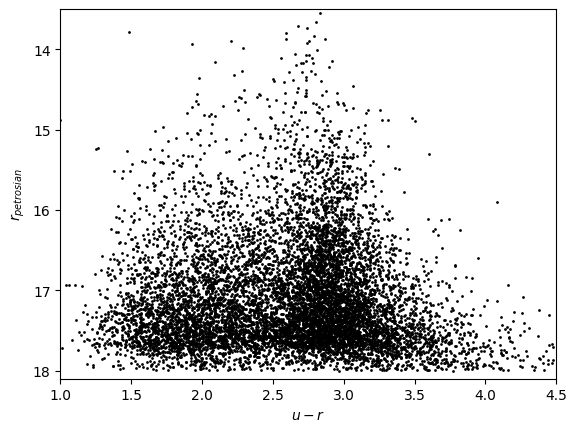

In [39]:
ax = plt.axes()
ax.scatter(u-r, rPetro, s=4, lw=0, c='k')
ax.set_xlim(1, 4.5)
ax.set_ylim(18.1, 13.5)
ax.set_xlabel('$u - r$')
ax.set_ylabel('$r_{petrosian}$')

The r vs. u -- r color-magnitude diagram for the first 10,000 entries in the catalog of spectroscopically observed galaxies from the Sloan Digital Sky Survy (SDSS). Note two "clouds" of points with different morphologies separated by u - r ≈ 2.3. The abrupt decrease of the point density for r > 17.7 (the bottom of the diagram) is due to the selection function for the spectroscopic galaxy sample from SDSS